In [1]:
import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]
filenames
grouped_list = [filenames[i:i+2] for i in range(0, 8, 2)]
grouped_list

re.findall("row", grouped_list[1][0])

['row']

In [2]:
filenames

['result_10_1_init_15000.json',
 'result_10_1_init_15000_damaged.json',
 'result_10_1_init_15000_row.json',
 'result_10_1_init_15000_row_damaged.json',
 'result_10_1_init_5000.json',
 'result_10_1_init_5000_damaged.json',
 'result_10_1_init_5000_row.json',
 'result_10_1_init_5000_row_damaged.json',
 'result_16_2_init_10000.json',
 'result_16_2_init_10000_damaged.json',
 'result_16_2_init_10000_row.json',
 'result_16_2_init_10000_row_damaged.json',
 'result_16_2_init_10000_sensor.json',
 'result_16_2_init_10000_sensor_damaged.json',
 'result_16_2_init_15000.json',
 'result_16_2_init_15000_damaged.json',
 'result_16_2_init_15000_row.json',
 'result_16_2_init_15000_row_damaged.json',
 'result_16_2_init_15000_row_weighedloss.json',
 'result_16_2_init_15000_row_weighedloss_damaged.json',
 'result_16_2_init_15000_sensor.json',
 'result_16_2_init_15000_sensor_damaged.json',
 'result_16_2_init_5000.json',
 'result_16_2_init_5000_damaged.json',
 'result_16_2_init_5000_row .json',
 'result_16_2_

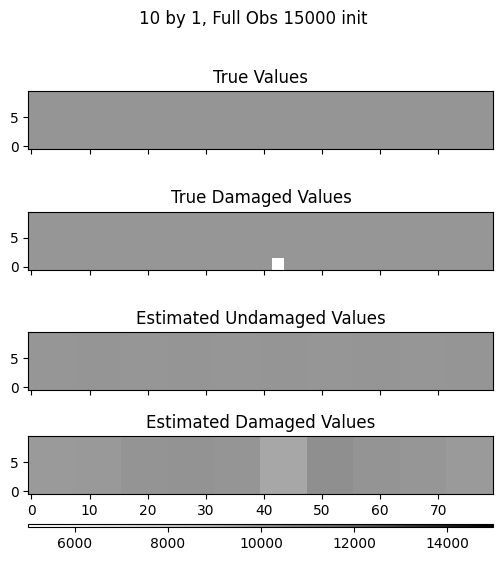

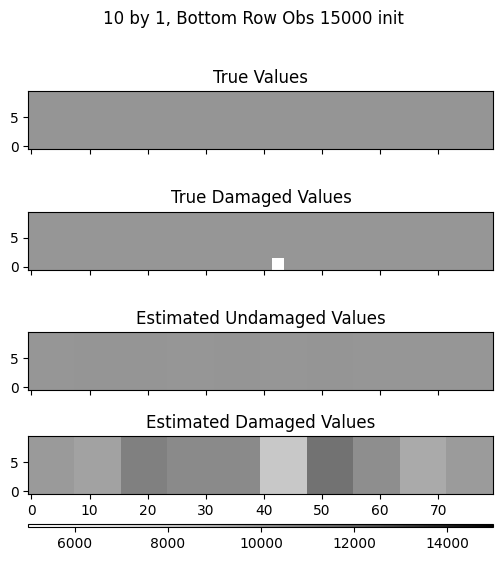

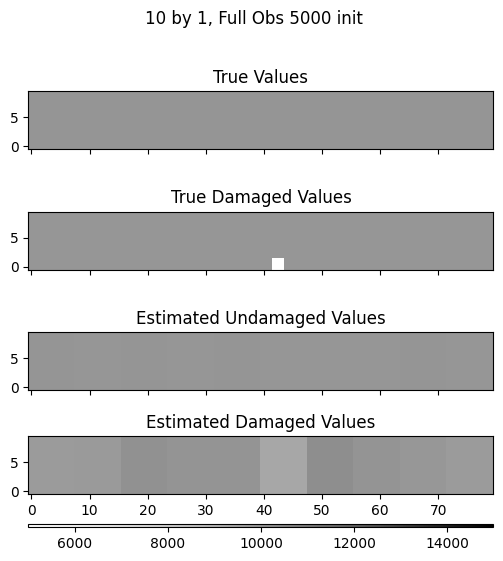

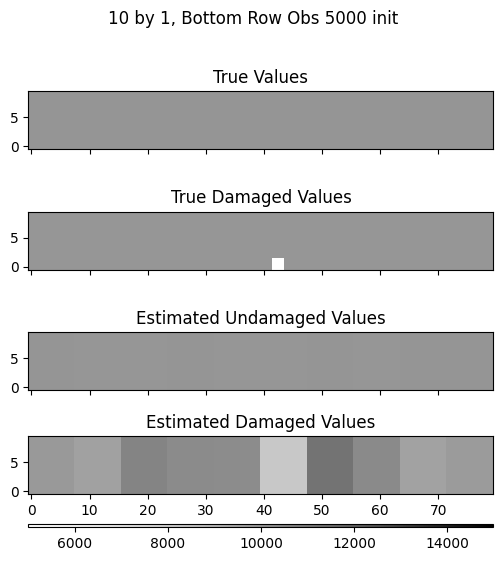

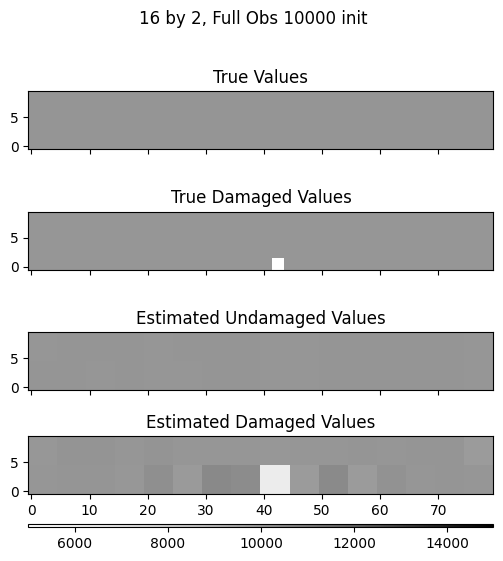

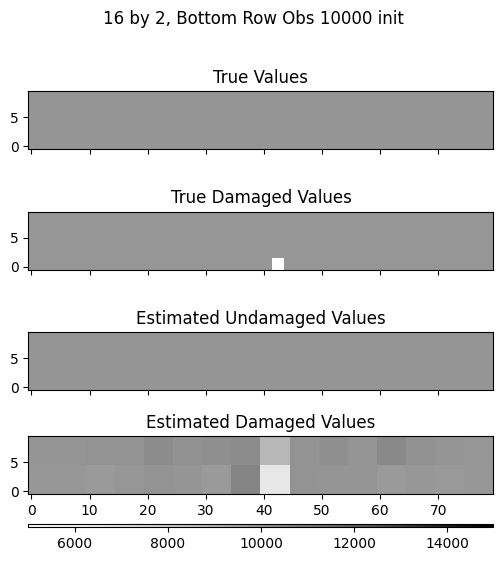

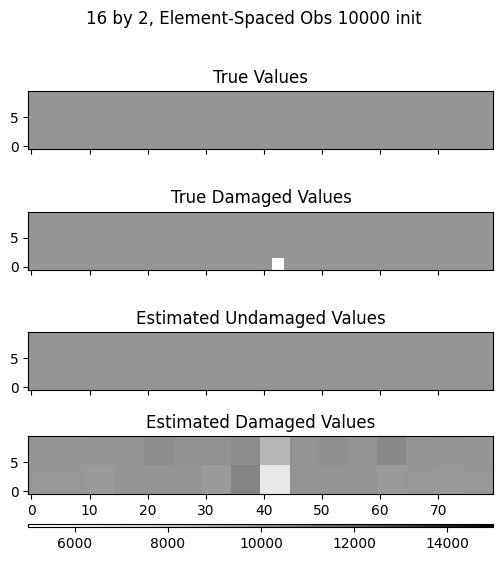

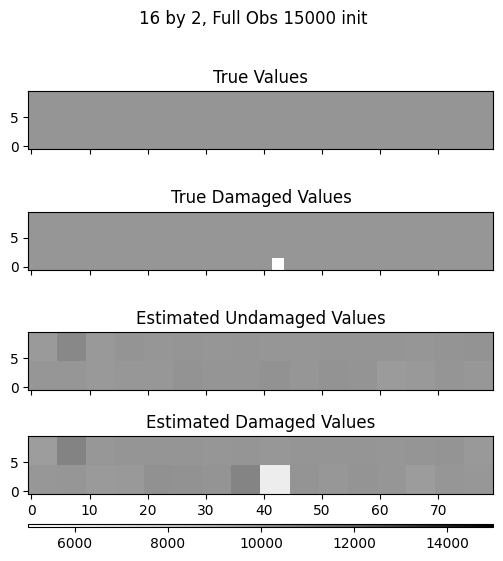

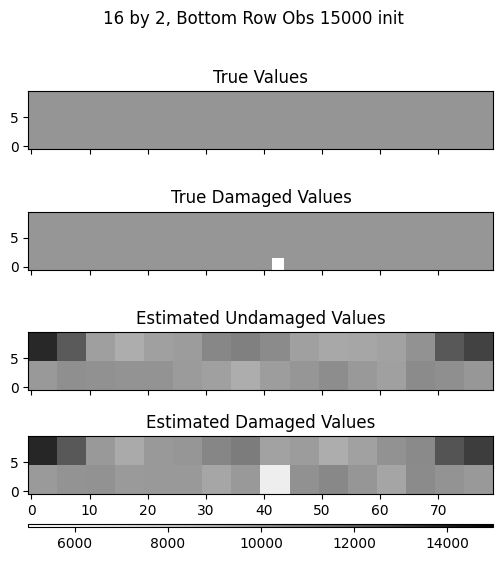

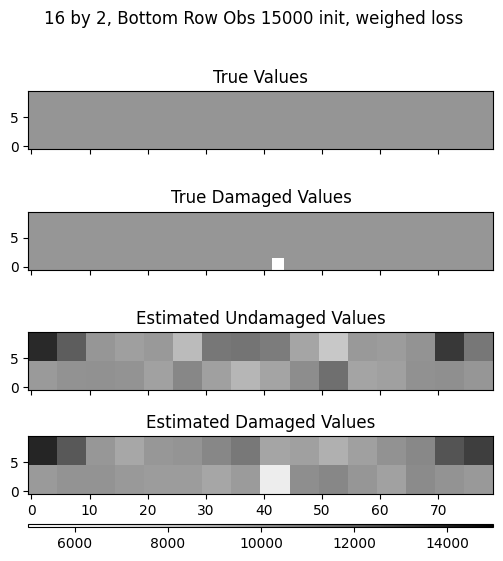

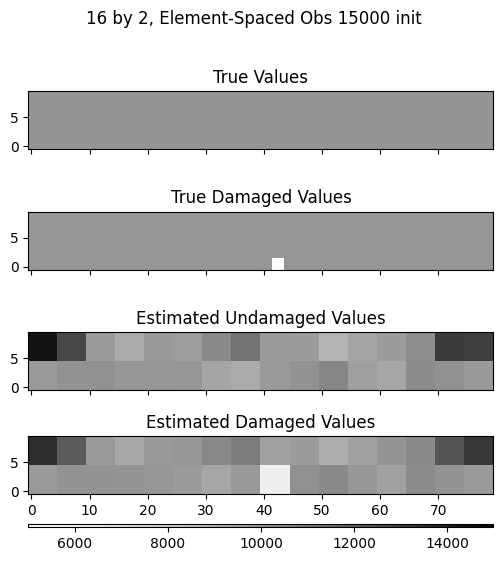

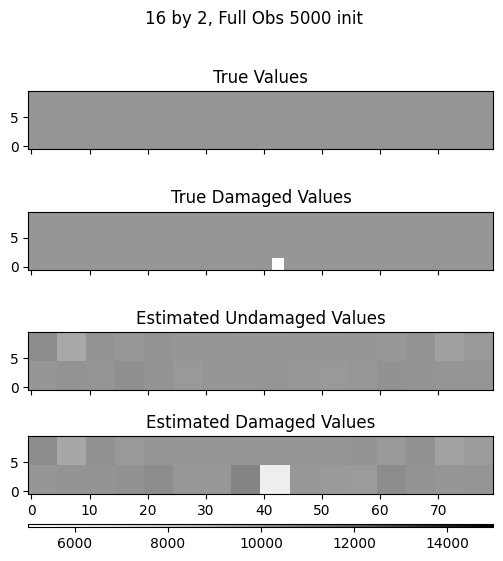

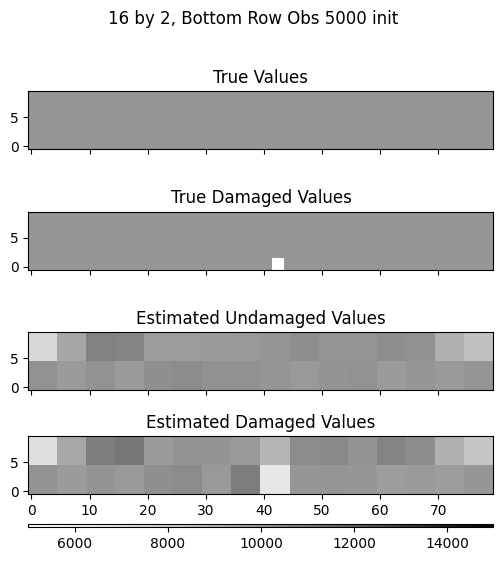

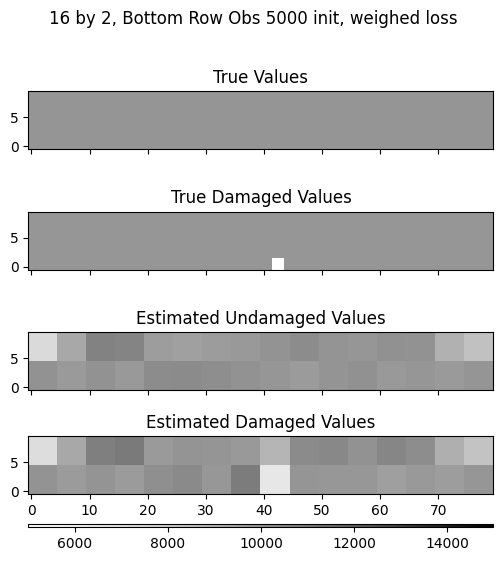

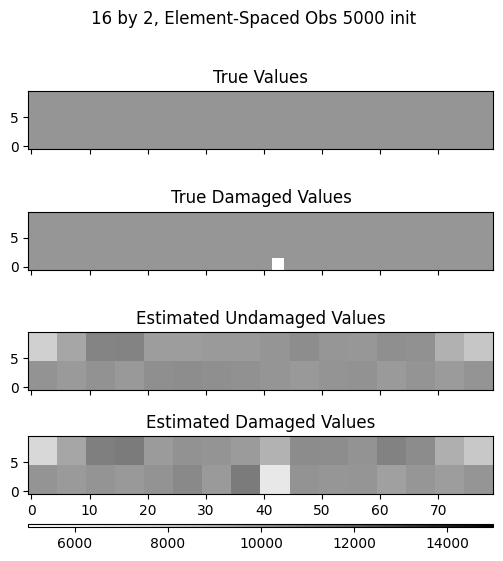

In [ ]:
import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]


E_hists = []
results = []
avg_err = []
avg_err_damaged = []


Nx = 80
Ny = 10
n_particles = Nx * Ny
E_true = np.zeros(n_particles)
E_damaged = np.zeros(n_particles)

for i in range(n_particles):
    col = i % Nx
    E_true[i] = 10000
    E_damaged[i] = 10000

E_damaged[42] = 1000
E_damaged[43] = 1000
E_damaged[122] = 1000
E_damaged[123] = 1000



grouped_list = [filenames[i:i+2] for i in range(0, len(filenames), 2)]
grouped_list

pattern = r"result_(\d+)_(\d+)_init"



    

for group in grouped_list:
    name = group[0]
    name_damaged = group[1]
    with open(name) as json_file:
        result = json.load(json_file)['E_hist'][-1]        
    with open(name_damaged) as json_file:
        result_damaged = json.load(json_file)['E_hist'][-1]     

    if re.search(pattern, name):
        match = re.search(pattern, name)
        n_blocks_x = int(match.group(1))
        n_blocks_y = int(match.group(2))

        n_blocks = n_blocks_y * n_blocks_x
        block_nx = int(Nx / n_blocks_x)
        block_ny = int(Ny / n_blocks_y)
    else:
        n_blocks_x = 10
        n_blocks_y = 1
        n_blocks = n_blocks_y * n_blocks_x
        block_nx = int(Nx / n_blocks_x)
        block_ny = int(Ny / n_blocks_y)



    if re.findall("row", name):
        obs = 'Bottom Row Obs '
    elif re.findall("sensor", name):
        obs = 'Element-Spaced Obs '
    else:
        obs = 'Full Obs '

    if re.findall("weighedloss", name):
        weighed_loss=True
    else:
        weighed_loss=False

    start = re.findall("init_(\d*)", name)[0]

    E = np.zeros(n_particles)
    E2 = np.zeros(n_particles)
    for i in range(Nx):
        for j in range(Ny):
            block_index_x = i // block_nx
            block_index_y = j // block_ny
            E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
            E2[j*Nx+i] = result_damaged[block_index_x + block_index_y * n_blocks_x]

    E_true_reshape = einops.rearrange(E_true, "(y x) -> x y", y=Ny)
    E_damaged_reshape = einops.rearrange(E_damaged, "(y x) -> x y", y=Ny)
    E_reshape = einops.rearrange(E, "(y x) -> x y", y=Ny)
    E2_reshape = einops.rearrange(E2, "(y x) -> x y", y=Ny)
    error = np.abs(np.divide((E_reshape - E_true_reshape), E_true_reshape))
    error_damaged = np.abs(np.divide((E2_reshape - E_damaged_reshape), E_damaged_reshape))
    avg_err.append(np.mean(error.flatten()))
    avg_err_damaged.append(np.mean(error_damaged.flatten()))

    fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=(6,6))
    title = str(n_blocks_x) + ' by ' + str(n_blocks_y) + ", " + obs + start + " init"

    if weighed_loss:
        title = title + ", weighed loss"

    fig.suptitle(title)

    axs[0].imshow(E_true_reshape.transpose(), origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
    axs[0].set_title('True Values')

    axs[1].imshow(E_damaged_reshape.transpose(), origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
    axs[1].set_title('True Damaged Values')
    
    im1 = axs[2].imshow(E_reshape.transpose(), origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
    axs[2].set_title('Estimated Undamaged Values')
    # divider1 = make_axes_locatable(axs[2])
    # cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
    # fig.colorbar(im1, cax=cax1, orientation='horizontal')

    im2 = axs[3].imshow(E2_reshape.transpose(), origin='lower', cmap='Greys', vmin=5000, vmax=15000)
    axs[3].set_title('Estimated Damaged Values')
    divider2 = make_axes_locatable(axs[3])
    cax2 = divider2.append_axes("bottom", size="5%", pad=0.3)
    fig.colorbar(im2, cax=cax2, orientation='horizontal')
    plt.show()
    

    


In [23]:
filenames_1e4

['result_16_2_init_10000.json',
 'result_16_2_init_10000_damaged.json',
 'result_16_2_init_10000_row.json',
 'result_16_2_init_10000_row_damaged.json',
 'result_16_2_init_10000_sensor.json',
 'result_16_2_init_10000_sensor_damaged.json']

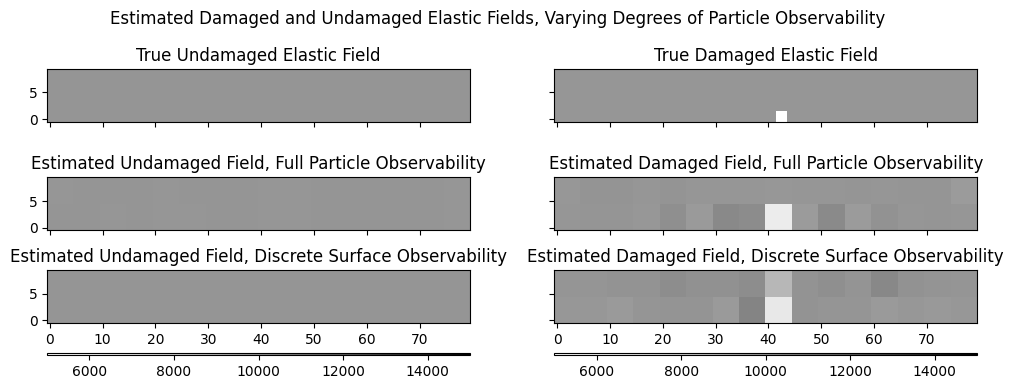

In [ ]:


import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]


filenames_1e4 = []
for name in filenames:
    if '10000' in name:
        filenames_1e4.append(name)



E_hists = []
results = []
avg_err = []
avg_err_damaged = []


Nx = 80
Ny = 10
n_particles = Nx * Ny
E_true = np.zeros(n_particles)
E_damaged = np.zeros(n_particles)

for i in range(n_particles):
    col = i % Nx
    E_true[i] = 10000
    E_damaged[i] = 10000

E_damaged[42] = 1000
E_damaged[43] = 1000
E_damaged[122] = 1000
E_damaged[123] = 1000



grouped_list = [filenames[i:i+2] for i in range(0, len(filenames), 2)]
grouped_list

pattern = r"result_(\d+)_(\d+)_init"



    
def result_reshape(name):
    with open(name) as json_file:
        result = json.load(json_file)['E_hist'][-1]   
    E = np.zeros(n_particles)
    for i in range(Nx):
        for j in range(Ny):
            block_index_x = i // block_nx
            block_index_y = j // block_ny
            E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
    return einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()

E_full = result_reshape('result_16_2_init_10000.json')
E_full_damaged = result_reshape('result_16_2_init_10000_damaged.json')

E_sensor = result_reshape('result_16_2_init_10000_sensor.json')
E_sensor_damaged = result_reshape('result_16_2_init_10000_sensor_damaged.json')



E_true_reshape = einops.rearrange(E_true, "(y x) -> x y", y=Ny)
E_damaged_reshape = einops.rearrange(E_damaged, "(y x) -> x y", y=Ny)


fig, axs = plt.subplots(3,2, sharex=True, sharey=True, figsize=(12,4))
title = str(n_blocks_x) + ' by ' + str(n_blocks_y) + ", " + obs + start + " init"

if weighed_loss:
    title = title + ", weighed loss"

fig.suptitle('Estimated Damaged and Undamaged Elastic Fields, Varying Degrees of Particle Observability')

axs[0, 0].imshow(E_true_reshape.transpose(), origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
axs[0, 0].set_title('True Undamaged Elastic Field')

axs[0, 1].imshow(E_damaged_reshape.transpose(), origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
axs[0, 1].set_title('True Damaged Elastic Field')

axs[1, 0].imshow(E_full, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
axs[1, 0].set_title('Estimated Undamaged Field, Full Particle Observability')

axs[1, 1].imshow(E_full_damaged, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
axs[1, 1].set_title('Estimated Damaged Field, Full Particle Observability')

im1 = axs[2, 0].imshow(E_sensor, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
axs[2, 0].set_title('Estimated Undamaged Field, Discrete Surface Observability')
divider1 = make_axes_locatable(axs[2, 0])
cax1 = divider1.append_axes("bottom", size="5%", pad=0.3)
fig.colorbar(im1, cax=cax1, orientation='horizontal')

im2 = axs[2, 1].imshow(E_sensor_damaged, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
axs[2, 1].set_title('Estimated Damaged Field, Discrete Surface Observability')
divider2 = make_axes_locatable(axs[2, 1])
cax2 = divider2.append_axes("bottom", size="5%", pad=0.3)
fig.colorbar(im2, cax=cax2, orientation='horizontal')
plt.show()
    

    


In [49]:
print(avg_err)
print(avg_err_damaged)

[0.0008567025148881839, 0.0008303789023999162, 0.00013149001630179556, 0.00037326746488584834, 6.579714707430072e-05, 0.0, 0.0, 0.006410660251243092, 0.0617753746406669, 0.07372966421391094, 0.06986301823938484, 0.008841378041535047, 0.03170020737343782, 0.033616133754475135, 0.03172084177636965]
[0.05650184947266218, 0.09817553465988552, 0.05836019881674475, 0.09304798565161868, 0.04556939013243361, 0.052253499774003884, 0.05218851532080124, 0.04603054013122195, 0.09572278888775104, 0.09784134426847746, 0.09351465870732872, 0.04974461846429944, 0.08008121997040778, 0.07960116601734318, 0.07860132661118337]


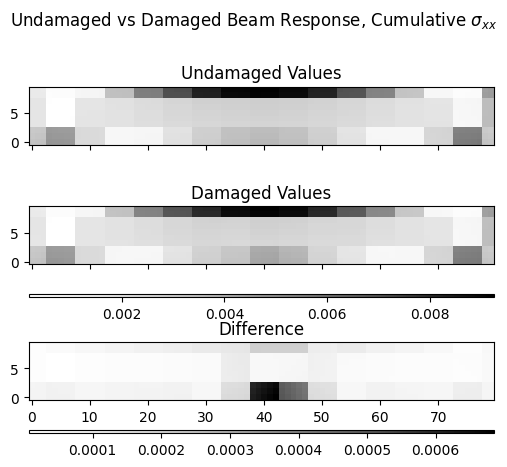

In [77]:
sxx_original = np.abs(np.load("strain2_true_original.npy")[:, :, 0, 0]).sum(axis=(0))
sxx_damaged = np.abs(np.load("strain2_true.npy")[:, :, 0, 0]).sum(axis=(0))

sxx_diff = np.load("strain2_true_original.npy") - np.load("strain2_true.npy")
sxx_diff = np.abs(sxx_diff[:, :, 0, 0]).sum(axis=0)

original_reshape = einops.rearrange(sxx_original, "(y x) -> x y", y=Ny)
damaged_reshape = einops.rearrange(sxx_damaged, "(y x) -> x y", y=Ny)
diff_reshape = einops.rearrange(sxx_diff, "(y x) -> x y", y=Ny)

fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(6,5))
title = "Undamaged vs Damaged Beam Response, Cumulative $\sigma_{xx}$"

fig.suptitle(title)

axs[0].imshow(original_reshape.transpose(), origin='lower', cmap='Greys')
axs[0].set_title('Undamaged Values')

im = axs[1].imshow(damaged_reshape.transpose(), origin='lower', cmap='Greys')
axs[1].set_title('Damaged Values')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("bottom", size="5%", pad=0.3)
fig.colorbar(im, cax=cax, orientation='horizontal')

im3 = axs[2].imshow(diff_reshape.transpose(), origin='lower', cmap='Greys')
axs[2].set_title('Difference')
divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes("bottom", size="5%", pad=0.3)
fig.colorbar(im3, cax=cax3, orientation='horizontal')


plt.show()

4001.4921875 3998.6083984375
4402.859375 2732.84814453125
4055.970703125 3940.46533203125
4536.65673828125 3331.809814453125


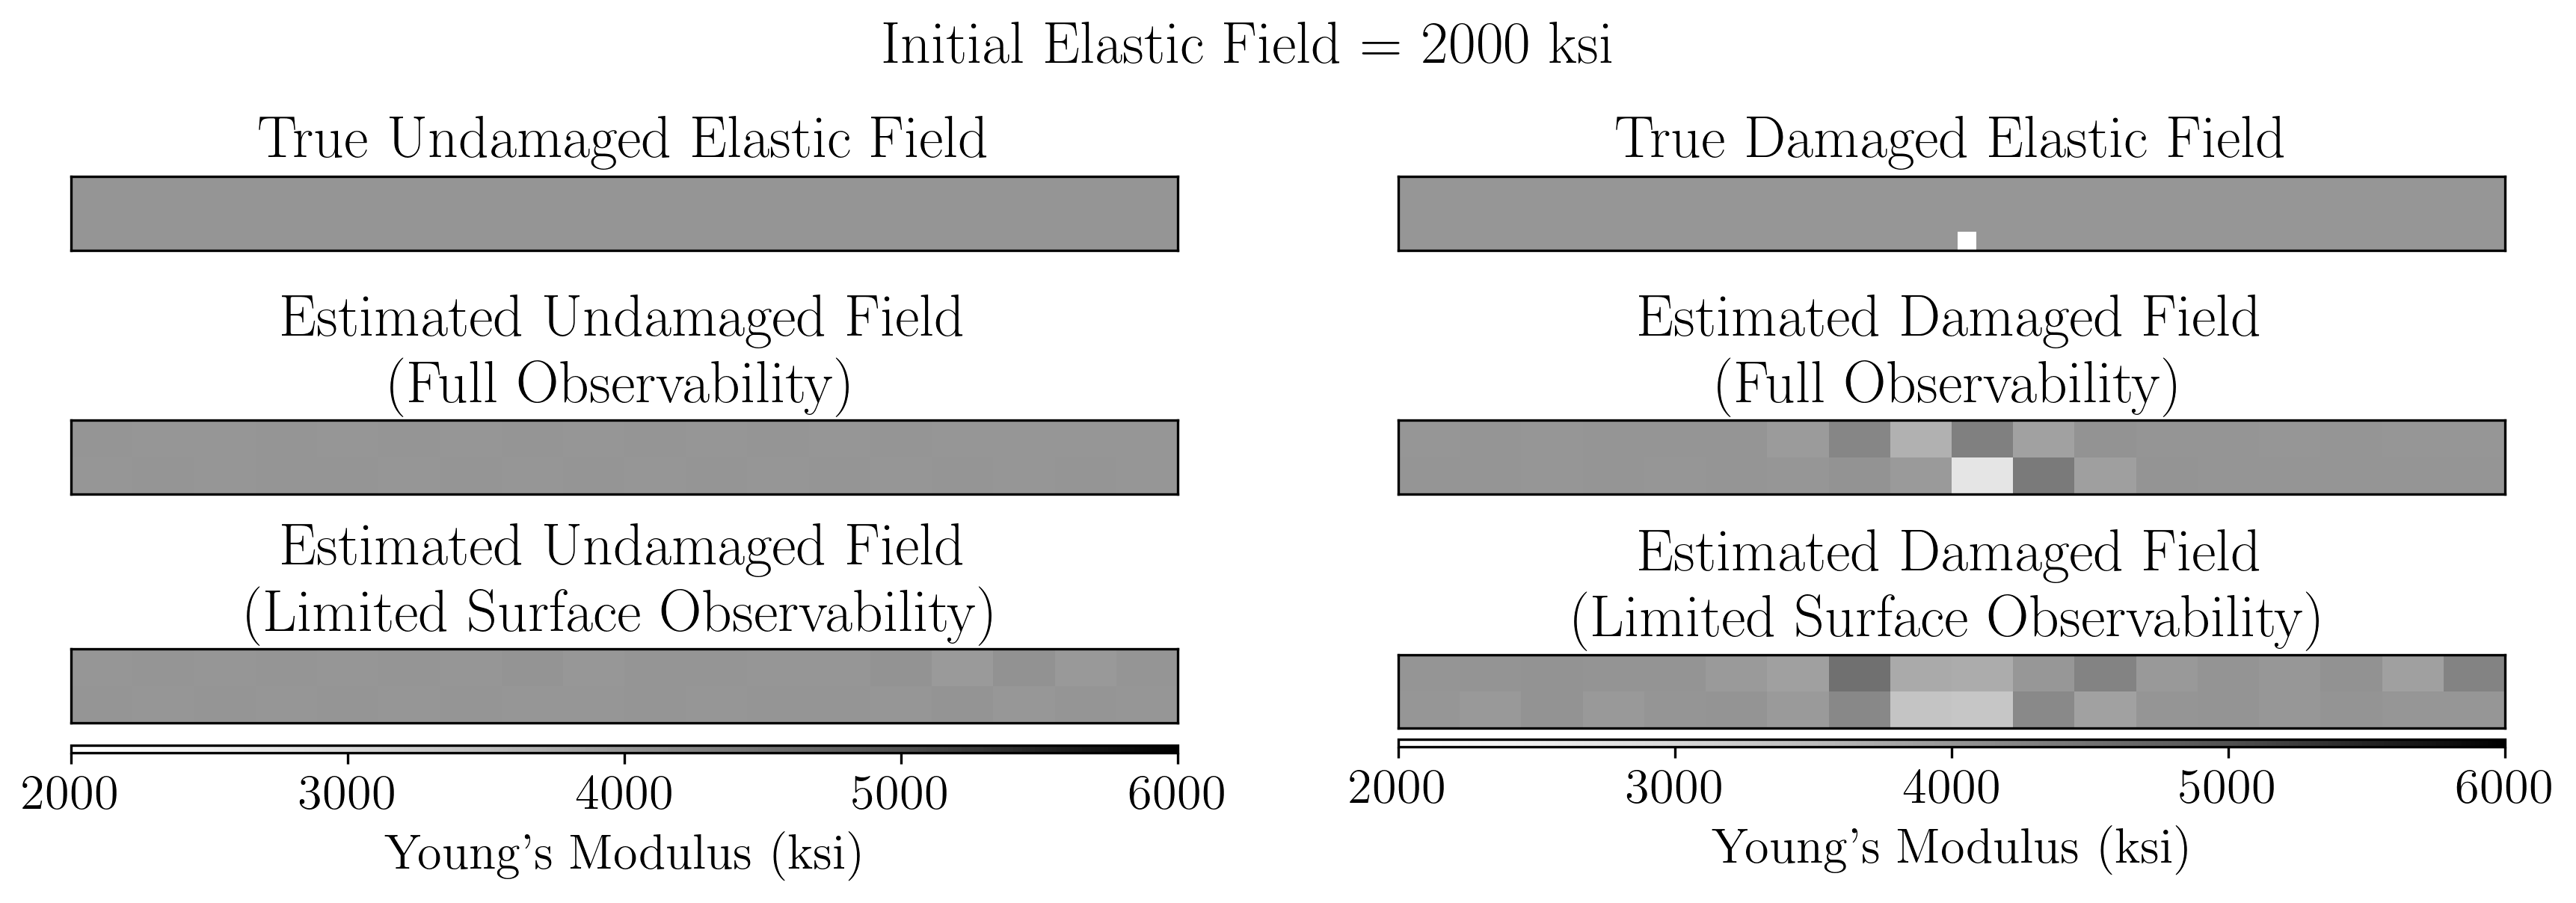

4000.001220703125 3999.998291015625
4408.47119140625 2726.4013671875
4000.0 4000.0
4511.091796875 3312.5166015625


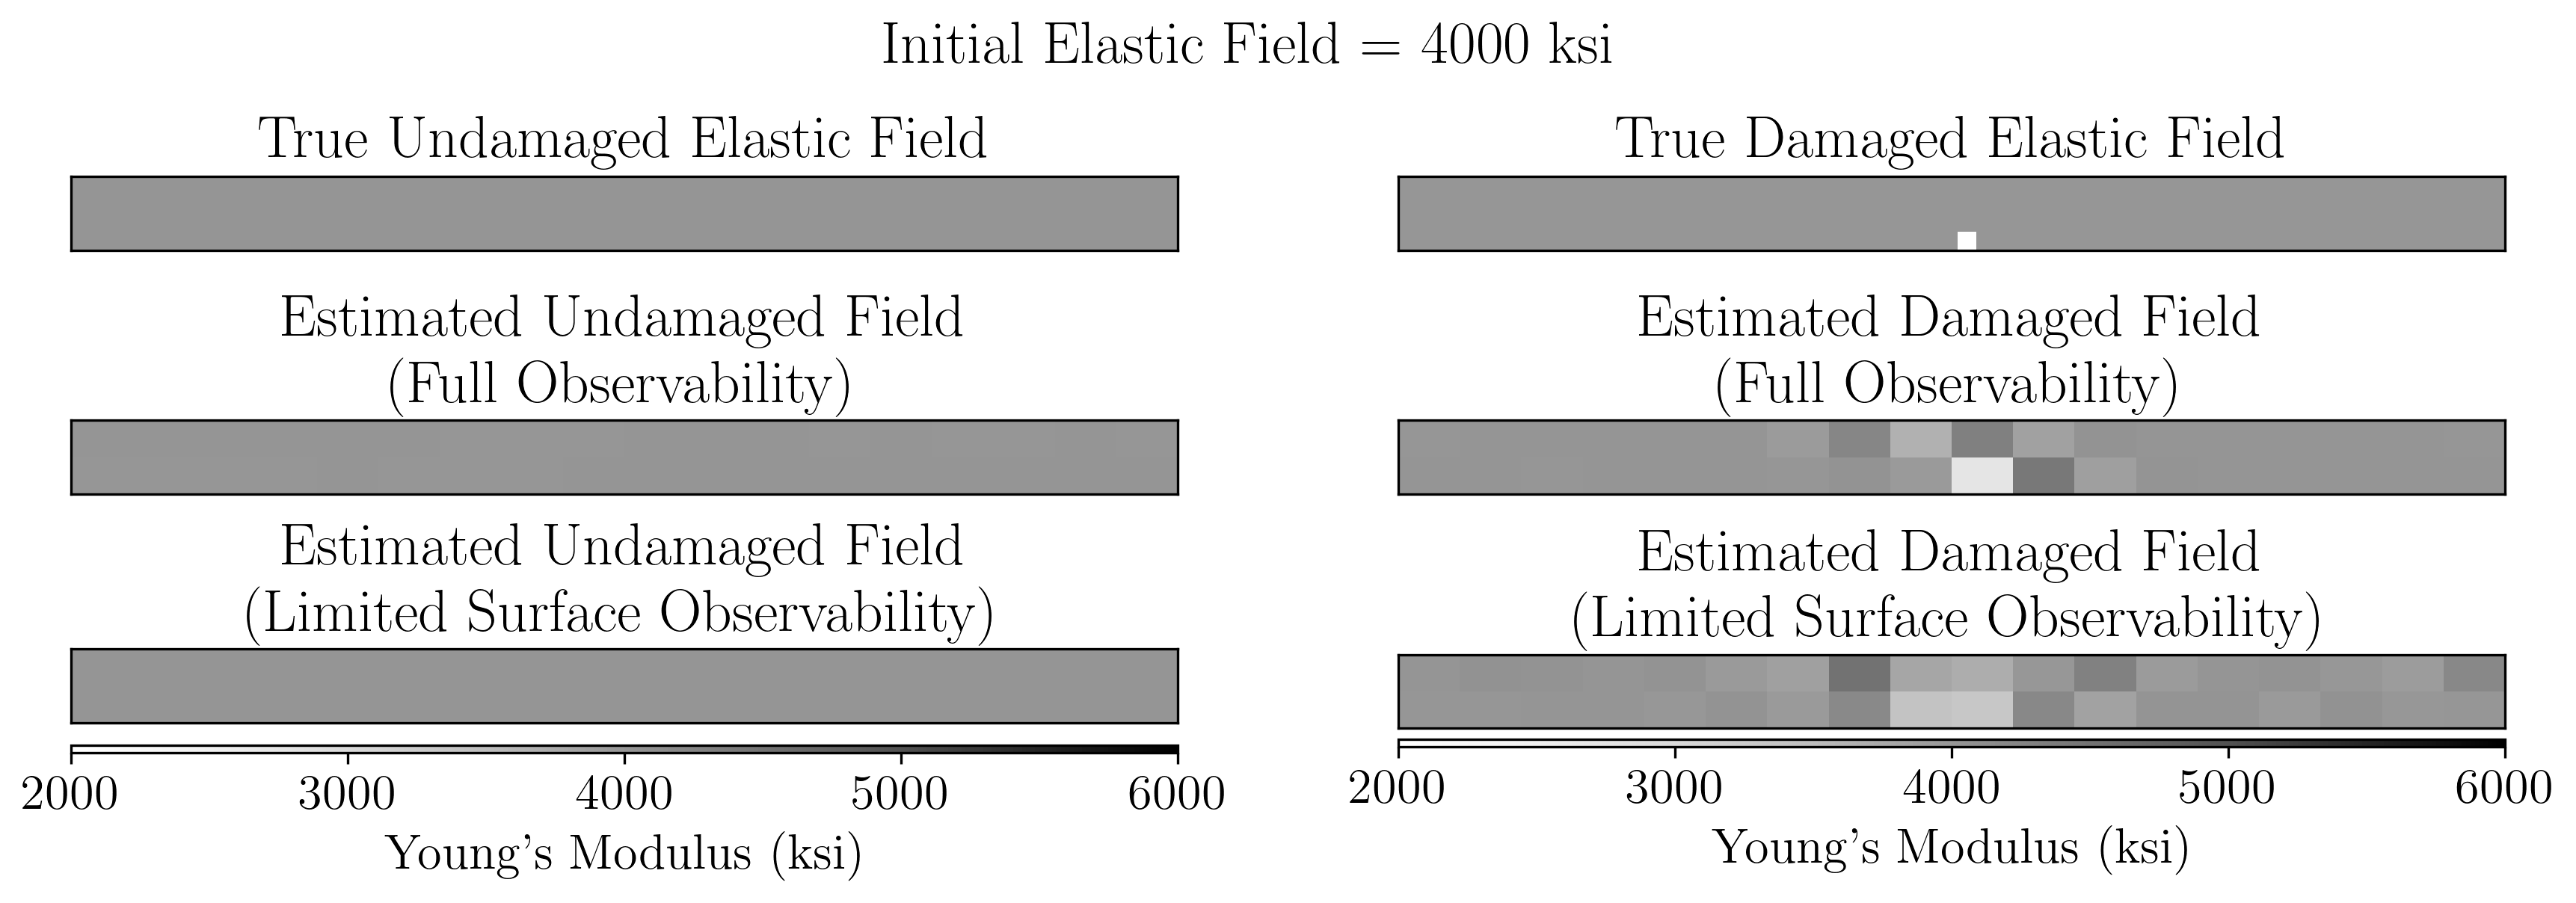

4000.60498046875 3999.318359375
4406.33447265625 2730.85498046875
4085.516357421875 3914.961669921875
4495.638671875 3282.928466796875


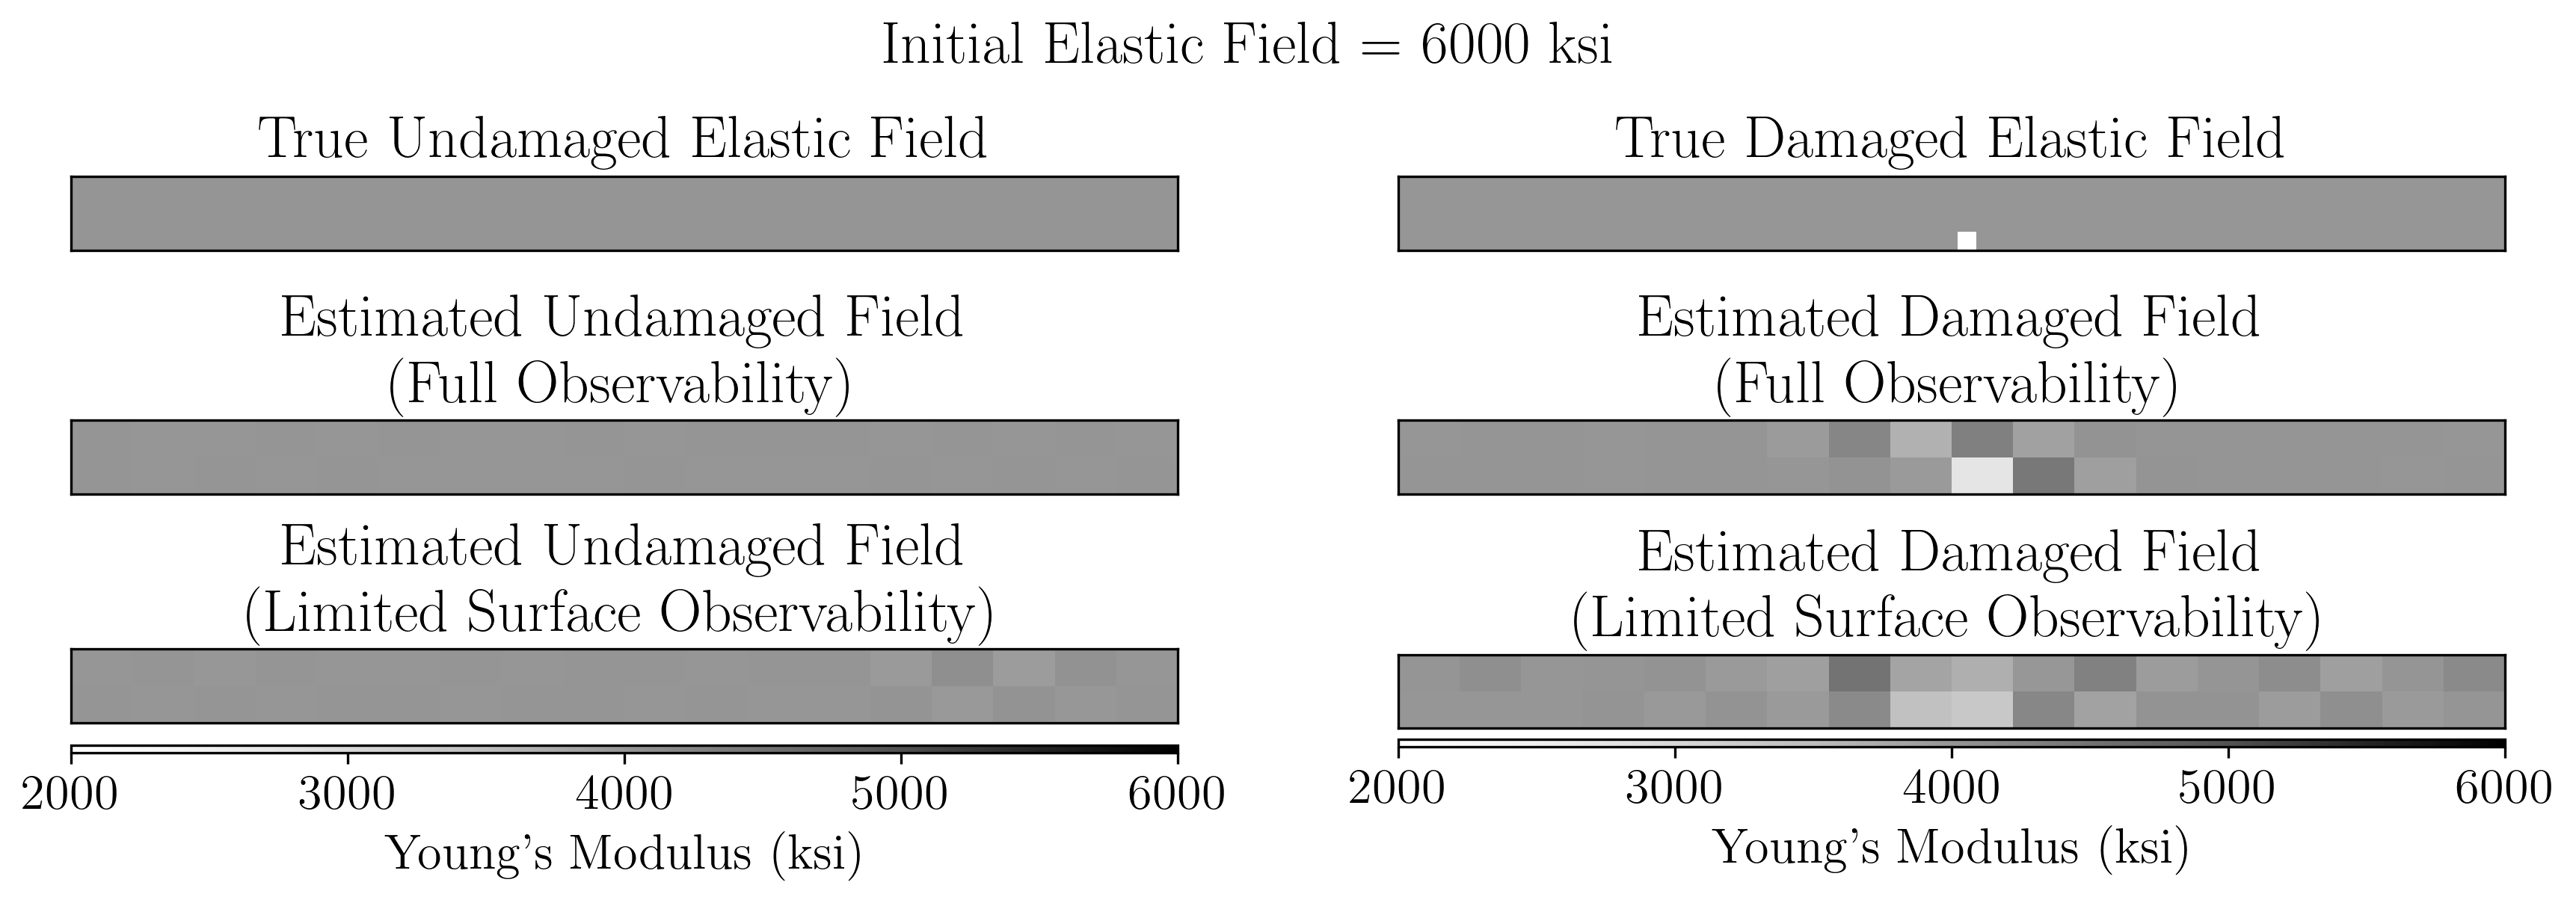

In [25]:
import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 16}
matplotlib.rc('font', **font)

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.startswith('r_c')]


E_hists = []
results = []
avg_err = []
avg_err_damaged = []


Nx = 180
Ny = 12
n_particles = Nx * Ny
E_true = np.zeros(n_particles)
E_damaged = np.zeros(n_particles)

n_blocks_x = 18
n_blocks_y = 2

n_blocks = n_blocks_y * n_blocks_x
block_nx = int(Nx / n_blocks_x)
block_ny = int(Ny / n_blocks_y)

for i in range(n_particles):
    col = i % Nx
    E_true[i] = 4000
    E_damaged[i] = 4000

for i in range(3):
    for j in range(3):
        E_damaged[91 + i + j*Nx] = 400




    
def result_reshape(name):
    with open(name) as json_file:
        result = json.load(json_file)['E_hist'][-1]   
    E = np.array(result)
    print(E.max(), E.min())
    return einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()

inits = ["2000", "4000", "6000"]
for init in inits:
    E_full = result_reshape(f'r_c_0_{init}_full_f.json')
    E_full_damaged = result_reshape(f'r_c_1_{init}_full_f.json')

    E_sensor = result_reshape(f'r_c_0_{init}_sensor_f.json')
    E_sensor_damaged = result_reshape(f'r_c_1_{init}_sensor_f.json')



    E_true_reshape = einops.rearrange(E_true, "(y x) -> x y", y=Ny)
    E_damaged_reshape = einops.rearrange(E_damaged, "(y x) -> x y", y=Ny)


    fig, axs = plt.subplots(3,2, sharex=True, sharey=True, figsize=(14,4))


    fig.suptitle(f'Initial Elastic Field  = {init} ksi')
    vmin = 2000
    vmax = 6000
    axs[0, 0].imshow(E_true_reshape.transpose(), origin='lower', cmap='Greys', vmin=vmin, vmax = vmax)
    axs[0, 0].set_title('True Undamaged Elastic Field')

    axs[0, 1].imshow(E_damaged_reshape.transpose(), origin='lower', cmap='Greys', vmin=vmin, vmax = vmax)
    axs[0, 1].set_title('True Damaged Elastic Field')

    axs[1, 0].imshow(E_full, origin='lower', cmap='Greys', vmin=vmin, vmax = vmax)
    axs[1, 0].set_title('Estimated Undamaged Field \n (Full Observability)')

    axs[1, 1].imshow(E_full_damaged, origin='lower', cmap='Greys', vmin=vmin, vmax = vmax)
    axs[1, 1].set_title('Estimated Damaged Field \n (Full Observability)')

    im1 = axs[2, 0].imshow(E_sensor, origin='lower', cmap='Greys', vmin=vmin, vmax = vmax)
    axs[2, 0].set_title('Estimated Undamaged Field \n (Limited Surface Observability)')
    divider1 = make_axes_locatable(axs[2, 0])
    cax1 = divider1.append_axes("bottom", size="10%", pad=0.1)
    fig.colorbar(im1, cax=cax1, orientation='horizontal', label='Young\'s Modulus (ksi)')

    im2 = axs[2, 1].imshow(E_sensor_damaged, origin='lower', cmap='Greys', vmin=vmin, vmax = vmax)
    axs[2, 1].set_title('Estimated Damaged Field \n (Limited Surface Observability)')
    divider2 = make_axes_locatable(axs[2, 1])
    cax2 = divider2.append_axes("bottom", size="10%", pad=0.05)
    fig.colorbar(im2, cax=cax2, orientation='horizontal', label='Young\'s Modulus (ksi)')

    for i in range(3):
            for j in range(2):
                axs[i, j].tick_params(
                    axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    left=False,
                    labelleft=False,
                    labelbottom=False)

    plt.savefig(f"D:/Research/Masonry-Rail/3 Damage ID/uniform_{init[0]}e3.jpg", dpi=300, bbox_inches="tight")
    plt.show()
    

    


[Taichi] Starting on arch=cuda


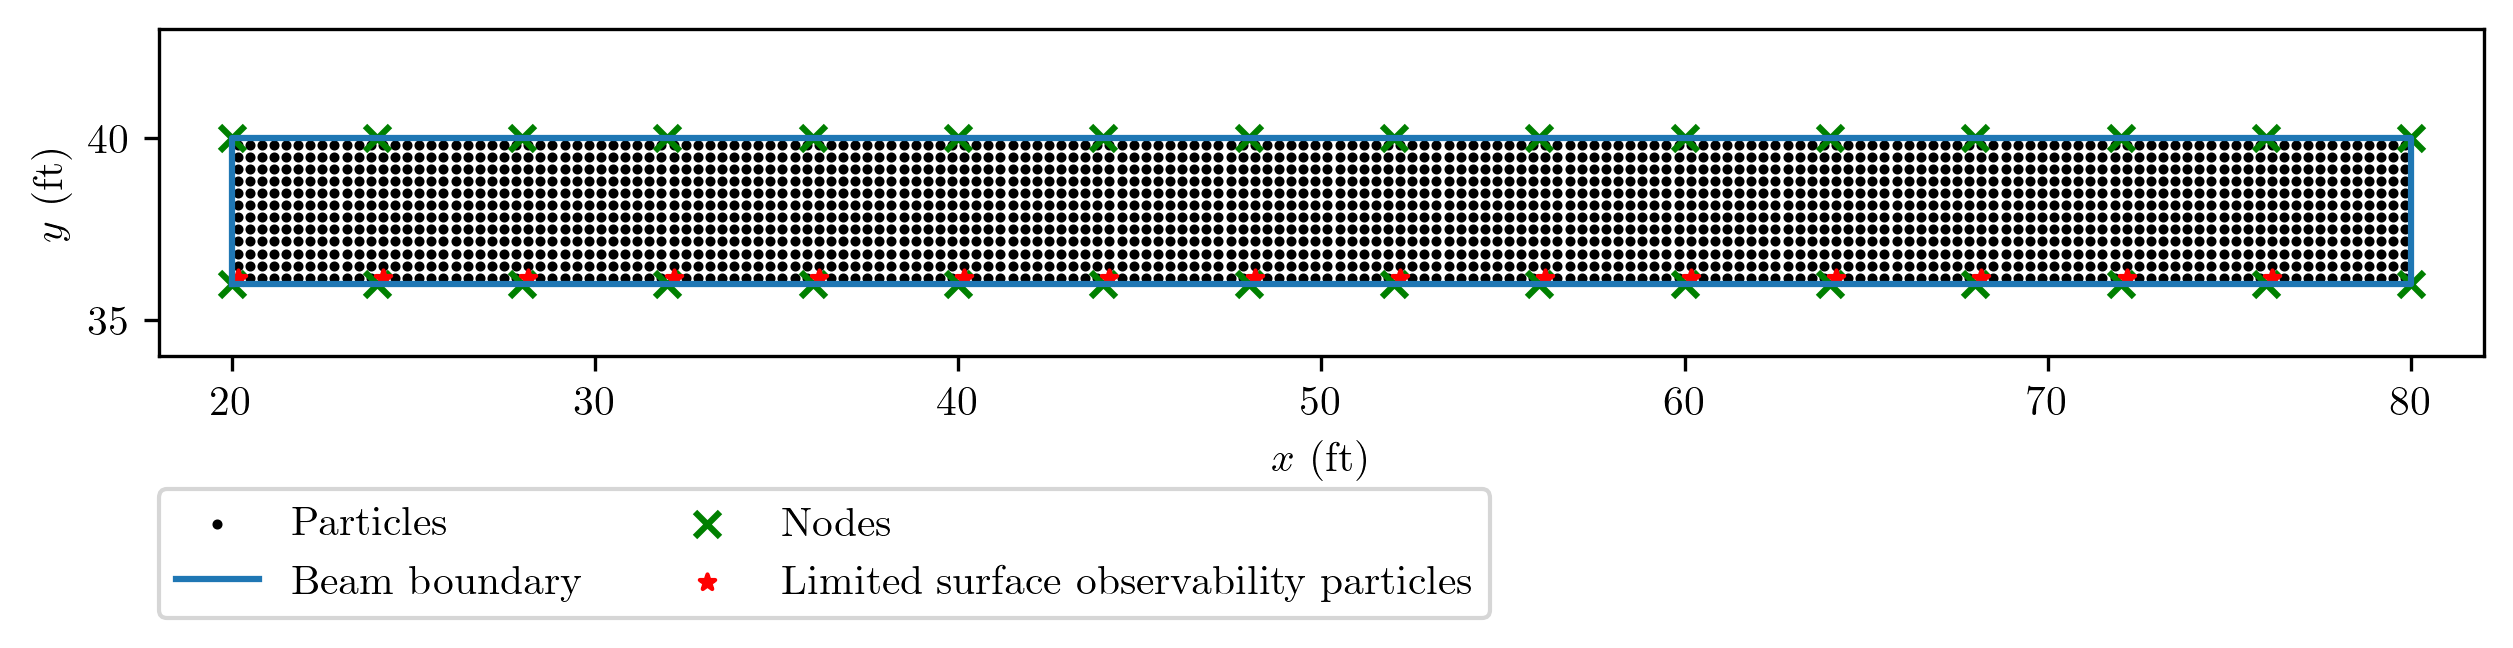

(2160, 2)

In [5]:
import taichi as ti
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

ti.reset()
real = ti.f32
ti.init(arch=ti.cuda, default_fp=real, device_memory_GB=12)
Nx = 180
Ny = 12
n_particles = Nx*Ny
size=100*12
x = ti.Vector.field(2,
                    dtype=real,
                    shape=(n_particles),
                    needs_grad=True)
x_p, y_p = np.zeros(n_particles), np.zeros(n_particles)
x_n, y_n = np.meshgrid(np.arange(16)*4+20, np.arange(2)*4+36)
for i in range(Nx):
    for j in range(Ny):
        x[j * Nx + i] = [
            ((i)/(Nx) * 0.6 + 0.2 + 0.6 / Nx * 0.5) * size/12, 
            ((j)/(Ny) * 0.04 + 0.36 + 0.04 / Ny * 0.5) * size/12]
        x_p[j * Nx + i] = ((i)/(Nx) * 0.6 + 0.2 + 0.6 / Nx * 0.5) * size/12
        y_p[j * Nx + i] = ((j)/(Ny) * 0.04 + 0.36 + 0.04 / Ny * 0.5) * size/12
n_particles = Nx * Ny

x_1, y_1 = np.array([]), np.array([])
x_2, y_2 = np.array([]), np.array([])
x_3, y_3 = np.array([]), np.array([])
x_4, y_4 = np.array([]), np.array([])

for i in range(n_particles):
    col = i % Nx
    if col < 45:
        x_1 = np.append(x_1, x_p[i])
        y_1 = np.append(y_1, y_p[i])
    elif col >= 45 and col < 90:
        x_2 = np.append(x_2, x_p[i])
        y_2 = np.append(y_2, y_p[i])
    elif col >= 90 and col < 135:
        x_3 = np.append(x_3, x_p[i])
        y_3 = np.append(y_3, y_p[i])
    else:
        x_4 = np.append(x_4, x_p[i])
        y_4 = np.append(y_4, y_p[i])

x = x.to_numpy()

matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 20}
def gray(level):
    return (level, level, level)

plt.figure(figsize=(10,3))
s=8
plt.scatter(x_1, y_1, color=gray(0), marker = '.',s=s, label='Particles')
plt.scatter(x_2, y_2, color=gray(0), marker = '.', s=s)
plt.scatter(x_3, y_3, color=gray(0), marker = '.', s=s)
plt.scatter(x_4, y_4, color=gray(0), marker = '.', s=s)
plt.plot(np.array([0.2, 0.8, 0.8, 0.2, 0.2])*size/12, np.array([0.36, 0.36, 0.4, 0.4, 0.36])*size/12, label='Beam boundary')
plt.scatter(x_n, y_n, color='g', marker='x', label='Nodes')
# plt.scatter(x[:,0], x[:,1], marker='.', label='800 (Full Observability)')
# plt.scatter(x[:180,0], x[:180,1], marker='D', s=3, color='blue', label='Surface observability particles')
plt.scatter(x[:180,0][::12], x[:180,1][::12], marker='*', color='r', s=15, label='Limited surface observability particles')

plt.legend(loc=(0, -0.8), ncol=2)
# plt.title('Material Points Used Per Observability Case')
plt.xlabel('$x$ (ft)')
plt.ylabel('$y$ (ft)')
plt.ylim((34,43))
plt.xlim((18,82))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
# plt.savefig('slender_beam.png', dpi=300, bbox_inches = "tight")
plt.show()

x.shape

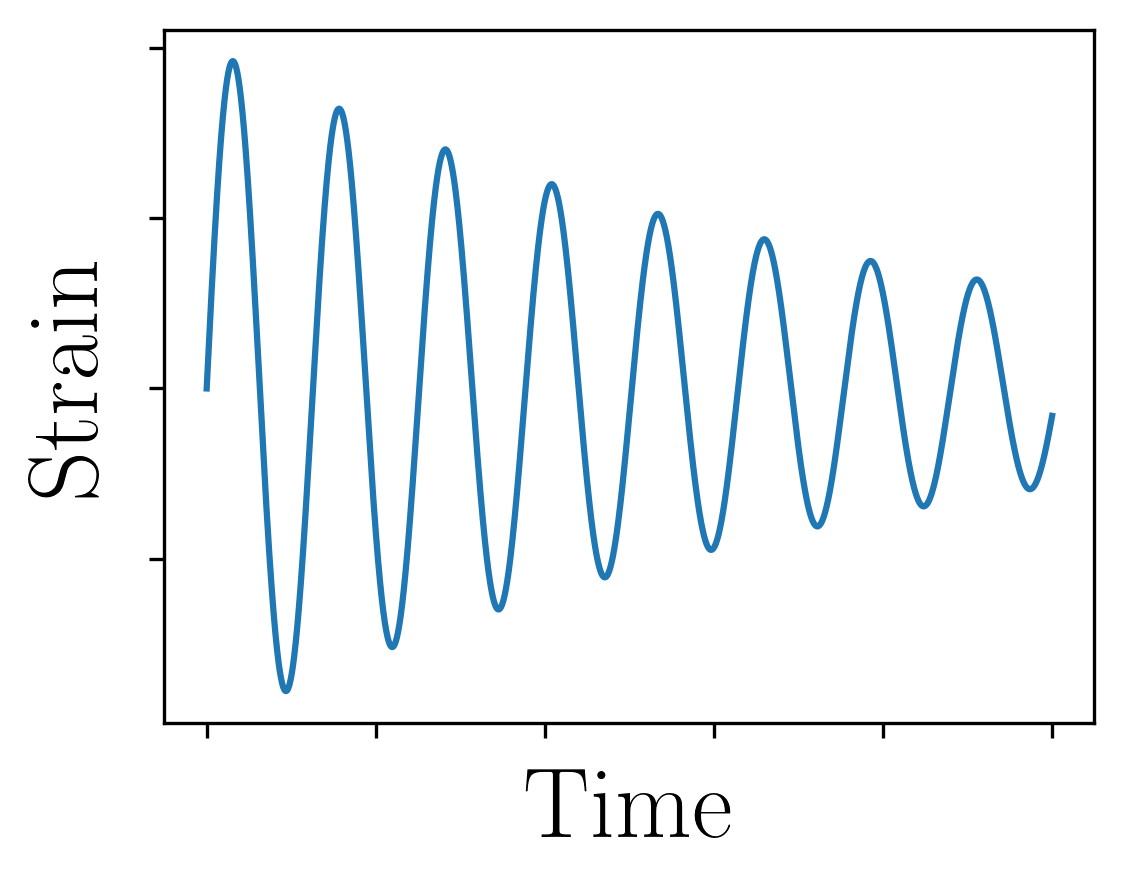

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 1.0       # mass
k = 100.0     # stiffness
c = 0.5       # damping coefficient
dt = 0.001    # time step
t_max = 5.0   # simulation time
impulse = 1.0 # impulse magnitude

# Derived parameters
omega_n = np.sqrt(k/m)
zeta = c / (2*np.sqrt(k*m))

# Time array
t = np.arange(0, t_max, dt)

# Initialize displacement (strain ~ displacement) and velocity
x = np.zeros_like(t)
v = np.zeros_like(t)

# Initial velocity from impulse: Impulse = m * Δv
v[0] = impulse / m

# Time integration (Newmark-beta method simplified to central difference)
for i in range(1, len(t)):
    a = ( -c*v[i-1] - k*x[i-1] ) / m
    v[i] = v[i-1] + a*dt
    x[i] = x[i-1] + v[i]*dt

# Plot
plt.figure(figsize=(4,3))
plt.plot(t, x,)
plt.xlabel("Time",fontsize=24)
plt.ylabel("Strain",fontsize=24)

# Remove ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.savefig("im.png", dpi=300)
plt.show()
